## 1. Environment Setup

In [1]:
# Environment setup
from pathlib import Path
from typing import Optional
import sys

try:
    from dotenv import load_dotenv
    DOTENV_AVAILABLE = True
except Exception:
    DOTENV_AVAILABLE = False

# Helper to find project root
def _find_root(start: Optional[Path] = None) -> Path:
    p = start or Path.cwd()
    for _ in range(6):
        if (p / 'data').exists() or (p / '.git').exists() or (p / 'notebooks').exists():
            return p
        p = p.parent
    return Path.cwd()

# Resolve project directories consistently
ROOT = _find_root()
DATA_DIR = ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
INTERIM_DIR = DATA_DIR / 'interim'
PROCESSED_DIR = DATA_DIR / 'processed'
ECONOMIC_DIR = DATA_DIR / 'economic_data'
FIG_DIR = ROOT / 'reports' / 'figures'

# Create directories
for d in [RAW_DIR, INTERIM_DIR, PROCESSED_DIR, ECONOMIC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"🎯 Environment setup complete")
print(f"   ROOT: {ROOT}")
print(f"   DATA_DIR: {DATA_DIR}")
print(f"   ECONOMIC_DIR: {ECONOMIC_DIR}")

🎯 Environment setup complete
   ROOT: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks
   DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data
   ECONOMIC_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data


## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 3. Load Budget Data Files

נטען את נתוני התקציבים שנאספו ממקורות שונים:
- **תקציב כולל של הליגה** (2008-2022) - ממקורות תקשורת שונים
- **תקציבי קבוצות ספציפיים** (2021-2025) - מ-Sport5 ומקורות אחרים  
- **הערכות Gemini AI** (2006-2024) - משוערך על בסיס טבלאות מהתקשורת

**⚠️ חשוב לזכור**: מדובר בנתונים משוערים שנאספו ממקורות שונים ויש להתייחס אליהם בזהירות.

In [3]:
# Load the three budget data files
budget_files = {
    'total_league': ECONOMIC_DIR / 'ligat_haal_total_budgets_mixed.csv',
    'club_budgets_2021_2025': ECONOMIC_DIR / 'ligat_haal_budgets_2021_2025.csv',
    'gemini_estimates': ECONOMIC_DIR / 'gemini_budget_estimates_2006_2024.csv'
}

# Read the files
try:
    # 1. Total league budgets (aggregate data)
    df_total_league = pd.read_csv(budget_files['total_league'])
    print(f"✅ Loaded total league budgets: {len(df_total_league)} records")
    
    # 2. Club-specific budgets 2021-2025
    df_club_budgets = pd.read_csv(budget_files['club_budgets_2021_2025'])
    print(f"✅ Loaded club budgets (2021-2025): {len(df_club_budgets)} records")
    
    # 3. Gemini AI estimates 2006-2024
    df_gemini = pd.read_csv(budget_files['gemini_estimates'])
    print(f"✅ Loaded Gemini estimates (2006-2024): {len(df_gemini)} records")
    
    print("\n📊 Data loaded successfully!")
    
except Exception as e:
    print(f"❌ Error loading files: {e}")

✅ Loaded total league budgets: 14 records
✅ Loaded club budgets (2021-2025): 56 records
✅ Loaded Gemini estimates (2006-2024): 90 records

📊 Data loaded successfully!


## 4. Explore Budget Data Structure

In [4]:
print("=" * 80)
print("1️⃣ TOTAL LEAGUE BUDGETS (Aggregate)")
print("=" * 80)
print(f"\nColumns: {list(df_total_league.columns)}")
print(f"Date range: {df_total_league['season'].min()} to {df_total_league['season'].max()}")
print(f"\nSample data:")
display(df_total_league.head())

print("\n" + "=" * 80)
print("2️⃣ CLUB BUDGETS 2021-2025 (Specific Teams)")
print("=" * 80)
print(f"\nColumns: {list(df_club_budgets.columns)}")
print(f"Seasons: {sorted(df_club_budgets['season'].unique())}")
print(f"Number of teams per season:")
display(df_club_budgets.groupby('season')['team_english'].count().to_frame('Teams'))
print(f"\nSample data (2024/25):")
display(df_club_budgets[df_club_budgets['season'] == '2024/25'].head(10))

print("\n" + "=" * 80)
print("3️⃣ GEMINI AI ESTIMATES 2006-2024")
print("=" * 80)
print(f"\nColumns: {list(df_gemini.columns)}")
print(f"Date range: {df_gemini['season'].min()} to {df_gemini['season'].max()}")
print(f"Unique teams: {df_gemini['team_english'].nunique()}")
print(f"\nNote: Includes 'Rest of league' category for smaller clubs")
print(f"\nSample data:")
display(df_gemini.head(10))

1️⃣ TOTAL LEAGUE BUDGETS (Aggregate)

Columns: ['season', 'total_league_budget_million_nis', 'source_note']
Date range: 2006/07 to 2024/25

Sample data:


,season,total_league_budget_million_nis,source_note
0,2008/09,475.3,Calcalist total league budgets (approx)
1,2009/10,405.8,Average of 412.4 (Calcalist) and 399.2 (Globes)
2,2010/11,464.0,Calcalist/Globes total league budgets (approx)
3,2011/12,422.8,Average of 451.6 (Calcalist) and 394 (Globes)
4,2012/13,423.0,Globes total league budgets



2️⃣ CLUB BUDGETS 2021-2025 (Specific Teams)

Columns: ['season', 'team_english', 'team_hebrew', 'budget_min_million_nis', 'budget_max_million_nis', 'source_note', 'budget_mid_million_nis']
Seasons: ['2021/22', '2022/23', '2023/24', '2024/25']
Number of teams per season:


,Teams
season,
2021/22,14
2022/23,14
2023/24,14
2024/25,14



Sample data (2024/25):


,season,team_english,team_hebrew,budget_min_million_nis,budget_max_million_nis,source_note,budget_mid_million_nis
0,2024/25,Maccabi Tel Aviv,"מכבי ת""א",120.0,120.0,Sport5 'ליגת הכסף' 24.8.2024,120.0
1,2024/25,Maccabi Haifa,מכבי חיפה,105.0,110.0,Range 105–110; Sport5,107.5
2,2024/25,Hapoel Be'er Sheva,"הפועל ב""ש",70.0,70.0,Sport5,70.0
3,2024/25,Beitar Jerusalem,"בית""ר ירושלים",51.0,51.0,Includes past debts; Sport5,51.0
4,2024/25,Hapoel Jerusalem,הפועל ירושלים,33.0,33.0,Includes women & youth; Sport5,33.0
5,2024/25,Maccabi Netanya,מכבי נתניה,31.0,31.0,Sport5,31.0
6,2024/25,Hapoel Haifa,הפועל חיפה,29.0,29.0,Includes youth department; Sport5,29.0
7,2024/25,Maccabi Petah Tikva,"מכבי פ""ת",26.0,26.0,Includes youth department; Sport5,26.0
8,2024/25,Hapoel Hadera,הפועל חדרה,22.0,22.0,Sport5,22.0
9,2024/25,Bnei Sakhnin,בני סכנין,20.5,20.5,Sport5,20.5



3️⃣ GEMINI AI ESTIMATES 2006-2024

Columns: ['season', 'team_english', 'team_hebrew', 'budget_min_million_nis', 'budget_max_million_nis', 'source_note', 'budget_mid_million_nis']
Date range: 2006/07 to 2023/24
Unique teams: 7

Note: Includes 'Rest of league' category for smaller clubs

Sample data:


,season,team_english,team_hebrew,budget_min_million_nis,budget_max_million_nis,source_note,budget_mid_million_nis
0,2006/07,Beitar Jerusalem,"בית""ר ירושלים",120.0,150.0,Gemini AI estimated range from media-based tab...,135.0
1,2006/07,Maccabi Haifa,מכבי חיפה,40.0,60.0,Gemini AI estimated range from media-based tab...,50.0
2,2006/07,Maccabi Tel Aviv,מכבי תל אביב,30.0,50.0,Gemini AI estimated range from media-based tab...,40.0
3,2006/07,Hapoel Tel Aviv,הפועל תל אביב,25.0,40.0,Gemini AI estimated range from media-based tab...,32.5
4,2006/07,Rest of league,שאר הליגה,5.0,20.0,Gemini AI estimated range from media-based tab...,12.5
5,2007/08,Beitar Jerusalem,"בית""ר ירושלים",120.0,150.0,Gemini AI estimated range from media-based tab...,135.0
6,2007/08,Maccabi Haifa,מכבי חיפה,40.0,60.0,Gemini AI estimated range from media-based tab...,50.0
7,2007/08,Maccabi Tel Aviv,מכבי תל אביב,30.0,50.0,Gemini AI estimated range from media-based tab...,40.0
8,2007/08,Hapoel Tel Aviv,הפועל תל אביב,25.0,40.0,Gemini AI estimated range from media-based tab...,32.5
9,2007/08,Rest of league,שאר הליגה,5.0,20.0,Gemini AI estimated range from media-based tab...,12.5


## 5. Create Combined Budget Dataset

נשלב את כל מקורות הנתונים לטבלה אחת מאוחדת עם אינדיקציה למקור המידע.

In [5]:
# Combine club-specific budgets (2021-2025 + Gemini estimates)
# Add source indicator
df_club_budgets['data_source'] = 'Sport5/Media (2021-2025)'
df_gemini['data_source'] = 'Gemini AI Estimate (2006-2024)'

# Combine the two club-level datasets
df_all_budgets = pd.concat([df_gemini, df_club_budgets], ignore_index=True)

# Sort by season and budget
df_all_budgets = df_all_budgets.sort_values(['season', 'budget_mid_million_nis'], ascending=[True, False])

print(f"✅ Combined budget dataset created!")
print(f"   Total records: {len(df_all_budgets)}")
print(f"   Date range: {df_all_budgets['season'].min()} to {df_all_budgets['season'].max()}")
print(f"   Unique teams: {df_all_budgets['team_english'].nunique()}")
print(f"\nData sources breakdown:")
display(df_all_budgets['data_source'].value_counts().to_frame('Count'))

print("\n" + "=" * 80)
print("Sample - Top budgets by season:")
display(df_all_budgets.groupby('season').head(3)[['season', 'team_english', 'budget_mid_million_nis', 'data_source']])

✅ Combined budget dataset created!
   Total records: 146
   Date range: 2006/07 to 2024/25
   Unique teams: 21

Data sources breakdown:


,Count
data_source,
Gemini AI Estimate (2006-2024),90
Sport5/Media (2021-2025),56



Sample - Top budgets by season:


,season,team_english,budget_mid_million_nis,data_source
0,2006/07,Beitar Jerusalem,135.0,Gemini AI Estimate (2006-2024)
1,2006/07,Maccabi Haifa,50.0,Gemini AI Estimate (2006-2024)
2,2006/07,Maccabi Tel Aviv,40.0,Gemini AI Estimate (2006-2024)
5,2007/08,Beitar Jerusalem,135.0,Gemini AI Estimate (2006-2024)
6,2007/08,Maccabi Haifa,50.0,Gemini AI Estimate (2006-2024)
7,2007/08,Maccabi Tel Aviv,40.0,Gemini AI Estimate (2006-2024)
10,2008/09,Beitar Jerusalem,110.0,Gemini AI Estimate (2006-2024)
14,2008/09,Maccabi Haifa,50.0,Gemini AI Estimate (2006-2024)
12,2008/09,Maccabi Tel Aviv,40.0,Gemini AI Estimate (2006-2024)
13,2009/10,Maccabi Tel Aviv,87.5,Gemini AI Estimate (2006-2024)


## 6. Budget Analysis - Key Metrics

In [6]:
# Calculate key budget metrics by season
budget_metrics = df_all_budgets.groupby('season').agg({
    'budget_mid_million_nis': ['sum', 'mean', 'max', 'min', 'std'],
    'team_english': 'count'
}).round(2)

budget_metrics.columns = ['Total_Budget_NIS_m', 'Avg_Budget_NIS_m', 'Max_Budget_NIS_m', 
                          'Min_Budget_NIS_m', 'Std_Budget_NIS_m', 'Num_Teams']

# Calculate inequality metrics
budget_metrics['Budget_Ratio_Max_Min'] = (budget_metrics['Max_Budget_NIS_m'] / 
                                           budget_metrics['Min_Budget_NIS_m']).round(2)

budget_metrics['Budget_Gini_Approx'] = (budget_metrics['Std_Budget_NIS_m'] / 
                                         budget_metrics['Avg_Budget_NIS_m']).round(3)

print("📊 Budget Metrics by Season")
print("=" * 80)
display(budget_metrics)

print("\n" + "=" * 80)
print("Key Insights:")
print(f"   💰 Highest total league budget: {budget_metrics['Total_Budget_NIS_m'].max():.0f}M NIS in {budget_metrics['Total_Budget_NIS_m'].idxmax()}")
print(f"   📈 Biggest budget disparity (max/min ratio): {budget_metrics['Budget_Ratio_Max_Min'].max():.1f}x in {budget_metrics['Budget_Ratio_Max_Min'].idxmax()}")
print(f"   📉 Smallest budget disparity: {budget_metrics['Budget_Ratio_Max_Min'].min():.1f}x in {budget_metrics['Budget_Ratio_Max_Min'].idxmin()}")

📊 Budget Metrics by Season


,Total_Budget_NIS_m,Avg_Budget_NIS_m,Max_Budget_NIS_m,Min_Budget_NIS_m,Std_Budget_NIS_m,Num_Teams,Budget_Ratio_Max_Min,Budget_Gini_Approx
season,,,,,,,,
2006/07,270.0,54.00,135.0,12.5,47.32,5,10.80,0.876
2007/08,270.0,54.00,135.0,12.5,47.32,5,10.80,0.876
2008/09,245.0,49.00,110.0,12.5,36.77,5,8.80,0.750
2009/10,221.5,44.30,87.5,11.5,27.98,5,7.61,0.632
2010/11,260.0,52.00,105.0,12.5,34.70,5,8.40,0.667
2011/12,242.0,48.40,88.0,11.5,29.14,5,7.65,0.602
2012/13,270.0,54.00,105.0,22.5,32.62,5,4.67,0.604
2013/14,285.0,57.00,130.0,27.5,42.11,5,4.73,0.739
2014/15,315.5,63.10,125.0,32.5,40.54,5,3.85,0.642



Key Insights:
   💰 Highest total league budget: 893M NIS in 2023/24
   📈 Biggest budget disparity (max/min ratio): 10.9x in 2016/17
   📉 Smallest budget disparity: 3.9x in 2014/15


## 7. Top Budget Teams Over Time

In [7]:
# Identify top budget teams per season
top_budget_teams = df_all_budgets.loc[df_all_budgets.groupby('season')['budget_mid_million_nis'].idxmax()]

print("🏆 Team with Highest Budget Each Season")
print("=" * 80)
display(top_budget_teams[['season', 'team_english', 'budget_mid_million_nis', 'data_source']].sort_values('season'))

# Count how many times each team had the highest budget
print("\n" + "=" * 80)
print("📊 Frequency of Highest Budget by Team:")
top_team_counts = top_budget_teams['team_english'].value_counts()
display(top_team_counts.to_frame('Times as Top Budget'))

# Get top 3 budgets for recent seasons
print("\n" + "=" * 80)
print("💰 Top 3 Budgets in Recent Seasons (2021-2025):")
recent_top3 = (df_all_budgets[df_all_budgets['season'].str.startswith(('2021', '2022', '2023', '2024'))]
               .groupby('season')
               .apply(lambda x: x.nlargest(3, 'budget_mid_million_nis')[['team_english', 'budget_mid_million_nis']])
               .reset_index(level=1, drop=True))
display(recent_top3)

🏆 Team with Highest Budget Each Season


,season,team_english,budget_mid_million_nis,data_source
0,2006/07,Beitar Jerusalem,135.0,Gemini AI Estimate (2006-2024)
5,2007/08,Beitar Jerusalem,135.0,Gemini AI Estimate (2006-2024)
10,2008/09,Beitar Jerusalem,110.0,Gemini AI Estimate (2006-2024)
13,2009/10,Maccabi Tel Aviv,87.5,Gemini AI Estimate (2006-2024)
20,2010/11,Maccabi Tel Aviv,105.0,Gemini AI Estimate (2006-2024)
21,2011/12,Maccabi Tel Aviv,88.0,Gemini AI Estimate (2006-2024)
30,2012/13,Maccabi Tel Aviv,105.0,Gemini AI Estimate (2006-2024)
31,2013/14,Maccabi Tel Aviv,130.0,Gemini AI Estimate (2006-2024)
40,2014/15,Maccabi Tel Aviv,125.0,Gemini AI Estimate (2006-2024)
41,2015/16,Maccabi Tel Aviv,163.0,Gemini AI Estimate (2006-2024)



📊 Frequency of Highest Budget by Team:


,Times as Top Budget
team_english,
Maccabi Tel Aviv,16
Beitar Jerusalem,3



💰 Top 3 Budgets in Recent Seasons (2021-2025):


,team_english,budget_mid_million_nis
season,,
2021/22,Maccabi Tel Aviv,110.0
2021/22,Maccabi Haifa,110.0
2021/22,Maccabi Tel Aviv,100.0
2022/23,Maccabi Tel Aviv,112.5
2022/23,Maccabi Tel Aviv,110.0
2022/23,Maccabi Haifa,105.0
2023/24,Maccabi Tel Aviv,120.0
2023/24,Maccabi Haifa,105.0
2023/24,Maccabi Tel Aviv,105.0


## 8. Budget Visualizations

✅ Budget visualization saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\budget_analysis_overview.png


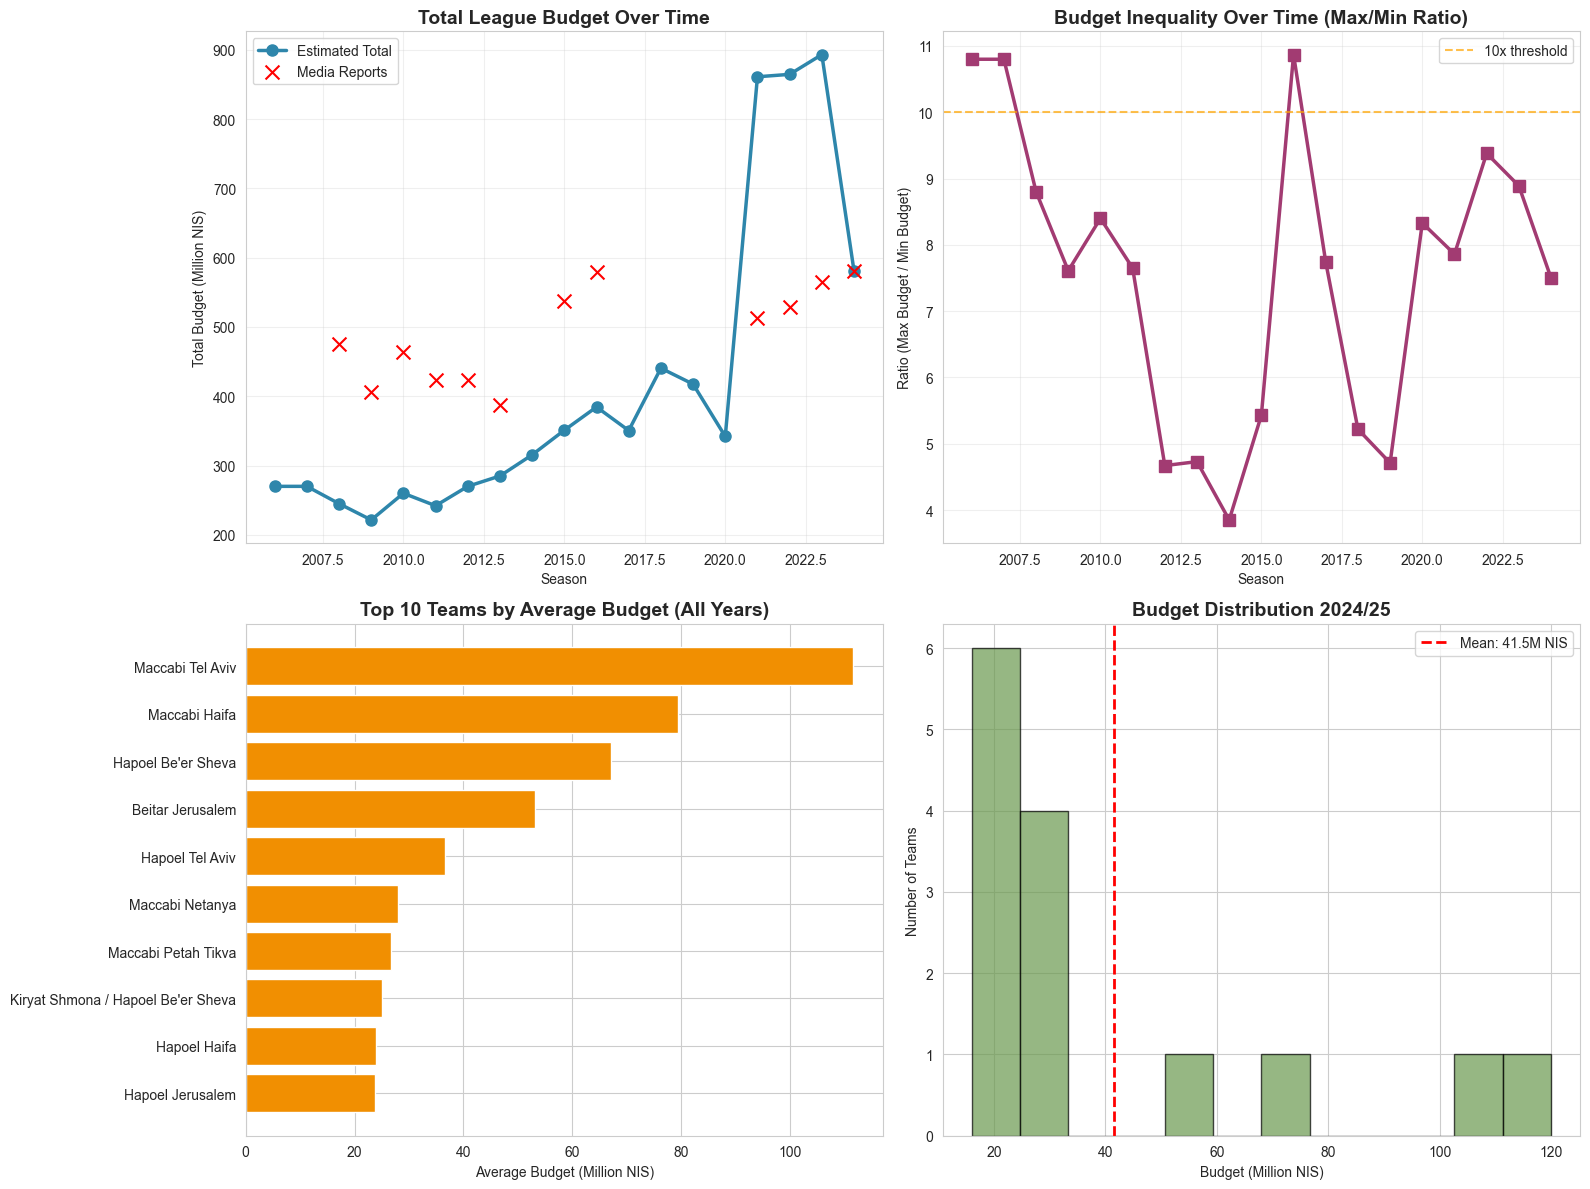

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for plotting
budget_metrics_sorted = budget_metrics.sort_index()
budget_metrics_sorted['season_year'] = budget_metrics_sorted.index.str[:4].astype(int)

# 1. Total league budget over time
axes[0, 0].plot(budget_metrics_sorted['season_year'], budget_metrics_sorted['Total_Budget_NIS_m'], 
                marker='o', linewidth=2.5, markersize=8, color='#2E86AB', label='Estimated Total')
axes[0, 0].set_title('Total League Budget Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Total Budget (Million NIS)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Add comparison with total_league data
if not df_total_league.empty:
    df_total_league_sorted = df_total_league.copy()
    df_total_league_sorted['season_year'] = df_total_league_sorted['season'].str[:4].astype(int)
    axes[0, 0].scatter(df_total_league_sorted['season_year'], 
                       df_total_league_sorted['total_league_budget_million_nis'],
                       marker='x', s=100, color='red', label='Media Reports', zorder=5)
    axes[0, 0].legend()

# 2. Budget inequality (Max/Min ratio)
axes[0, 1].plot(budget_metrics_sorted['season_year'], budget_metrics_sorted['Budget_Ratio_Max_Min'], 
                marker='s', linewidth=2.5, markersize=8, color='#A23B72')
axes[0, 1].set_title('Budget Inequality Over Time (Max/Min Ratio)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Ratio (Max Budget / Min Budget)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=10, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='10x threshold')
axes[0, 1].legend()

# 3. Top 5 teams - average budget
top_teams = df_all_budgets.groupby('team_english')['budget_mid_million_nis'].mean().nlargest(10)
axes[1, 0].barh(range(len(top_teams)), top_teams.values, color='#F18F01')
axes[1, 0].set_yticks(range(len(top_teams)))
axes[1, 0].set_yticklabels(top_teams.index)
axes[1, 0].set_title('Top 10 Teams by Average Budget (All Years)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Budget (Million NIS)')
axes[1, 0].invert_yaxis()

# 4. Budget distribution in 2024/25
if '2024/25' in df_all_budgets['season'].values:
    latest_budgets = df_all_budgets[df_all_budgets['season'] == '2024/25']['budget_mid_million_nis']
    axes[1, 1].hist(latest_budgets, bins=12, color='#6A994E', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Budget Distribution 2024/25', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Budget (Million NIS)')
    axes[1, 1].set_ylabel('Number of Teams')
    axes[1, 1].axvline(latest_budgets.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {latest_budgets.mean():.1f}M NIS')
    axes[1, 1].legend()

plt.tight_layout()

# Save figure
fig_path_budgets = FIG_DIR / 'budget_analysis_overview.png'
plt.savefig(fig_path_budgets, dpi=300, bbox_inches='tight')
print(f"✅ Budget visualization saved: {fig_path_budgets}")

plt.show()

## 9. Save Combined Budget Data

In [9]:
# Save the combined budget dataset
combined_budget_file = ECONOMIC_DIR / 'budget_data_combined_all_sources.csv'
df_all_budgets.to_csv(combined_budget_file, index=False, encoding='utf-8-sig')
print(f"✅ Saved combined budget data: {combined_budget_file}")
print(f"   Records: {len(df_all_budgets)}")
print(f"   Columns: {list(df_all_budgets.columns)}")

# Save the metrics summary
metrics_file = ECONOMIC_DIR / 'budget_metrics_by_season.csv'
budget_metrics.to_csv(metrics_file, encoding='utf-8-sig')
print(f"\n✅ Saved budget metrics: {metrics_file}")

# Save total league budgets separately
total_league_file = ECONOMIC_DIR / 'total_league_budgets_summary.csv'
df_total_league.to_csv(total_league_file, index=False, encoding='utf-8-sig')
print(f"✅ Saved total league budgets: {total_league_file}")

print("\n🎉 All budget data files saved successfully!")

✅ Saved combined budget data: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\budget_data_combined_all_sources.csv
   Records: 146
   Columns: ['season', 'team_english', 'team_hebrew', 'budget_min_million_nis', 'budget_max_million_nis', 'source_note', 'budget_mid_million_nis', 'data_source']

✅ Saved budget metrics: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\budget_metrics_by_season.csv
✅ Saved total league budgets: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\total_league_budgets_summary.csv

🎉 All budget data files saved successfully!


---

## סיכום ניתוח תקציבים

### 📊 מקורות המידע:
1. **תקציב כולל של הליגה** (2008-2022) - ממקורות תקשורת: Calcalist, Globes, Sport5, ONE
2. **תקציבי קבוצות ספציפיים** (2021-2025) - Sport5 ומקורות מדיה אחרים
3. **הערכות Gemini AI** (2006-2024) - משוערך מטבלאות תקשורתיות

### 💡 מדדים שחושבו:
- **פערי תקציבים** - יחס בין התקציב הגבוה לנמוך ביותר
- **אי-שוויון תקציבי** - מקדם Gini משוערך (סטיית תקן / ממוצע)
- **מגמות לאורך זמן** - שינויים בתקציב הכולל והפערים

### ⚠️ הערות חשובות:
- המידע משוערך ונאסף ממקורות שונים - **יש להתייחס בזהירות**
- יש עונות עם פערי מידע (חסרות עונות מסוימות)
- חלק מהנתונים כוללים "Rest of league" (שאר הקבוצות) כקטגוריה כללית
- תקציבים בש"ח (NIS) ולא באירו

### 📁 קבצים שנוצרו:
- `budget_data_combined_all_sources.csv` - כל הנתונים המאוחדים
- `budget_metrics_by_season.csv` - מדדים לפי עונה
- `total_league_budgets_summary.csv` - תקציבים כוללים של הליגה